In [1]:
# Customer Churn Prediction - Complete Pipeline
# Step 1: Setup and Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.metrics import roc_auc_score

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


In [2]:
# Step 2: Load Real Dataset from IBM GitHub
import pandas as pd
import numpy as np

print("="*50)
print("LOADING REAL TELCO CUSTOMER CHURN DATASET")
print("="*50)

# Load the dataset
url = "https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv"
df = pd.read_csv(url)

print("✅ Dataset loaded successfully!")
print(f"Original dataset shape: {df.shape}")

# Convert TotalCharges to numeric (it comes as string)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Drop rows with missing TotalCharges
initial_rows = len(df)
df = df.dropna(subset=['TotalCharges'])
print(f"Dropped {initial_rows - len(df)} rows with missing TotalCharges")

# Rename columns to match your existing pipeline
column_mapping = {
    'customerID': 'customer_id',
    'gender': 'gender',
    'SeniorCitizen': 'senior_citizen',
    'Partner': 'partner',
    'Dependents': 'dependents',
    'tenure': 'tenure',
    'PhoneService': 'phone_service',
    'MultipleLines': 'multiple_lines',
    'InternetService': 'internet_service',
    'OnlineSecurity': 'online_security',
    'OnlineBackup': 'online_backup',
    'DeviceProtection': 'device_protection',
    'TechSupport': 'tech_support',
    'StreamingTV': 'streaming_tv',
    'StreamingMovies': 'streaming_movies',
    'Contract': 'contract',
    'PaperlessBilling': 'paperless_billing',
    'PaymentMethod': 'payment_method',
    'MonthlyCharges': 'monthly_charges',
    'TotalCharges': 'total_charges',
    'Churn': 'churn'
}

df = df.rename(columns=column_mapping)

# Convert churn to binary (Yes=1, No=0)
df['churn'] = (df['churn'] == 'Yes').astype(int)

print(f"\n✅ Dataset ready for processing!")
print(f"Final dataset shape: {df.shape}")
print(f"\nChurn distribution:")
print(df['churn'].value_counts(normalize=True))
print(f"\nFirst 5 rows:")
print(df.head())

LOADING REAL TELCO CUSTOMER CHURN DATASET
✅ Dataset loaded successfully!
Original dataset shape: (7043, 21)
Dropped 11 rows with missing TotalCharges

✅ Dataset ready for processing!
Final dataset shape: (7032, 21)

Churn distribution:
churn
0   0.734
1   0.266
Name: proportion, dtype: float64

First 5 rows:
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  7590-VHVEG  Female               0     Yes         No       1   
1  5575-GNVDE    Male               0      No         No      34   
2  3668-QPYBK    Male               0      No         No       2   
3  7795-CFOCW    Male               0      No         No      45   
4  9237-HQITU  Female               0      No         No       2   

  phone_service    multiple_lines internet_service online_security  \
0            No  No phone service              DSL              No   
1           Yes                No              DSL             Yes   
2           Yes                No              DSL             Yes   
3

In [3]:
# Step 3: Dataset Understanding
print("="*50)
print("DATASET UNDERSTANDING")
print("="*50)

print("\nFirst 5 rows:")
print(df.head())

print("\nDataset Info:")
print(df.info())

print("\nStatistical Summary:")
print(df.describe())

print("\nMissing Values:")
print(df.isnull().sum())

print("\nData Types:")
print(df.dtypes.value_counts())

DATASET UNDERSTANDING

First 5 rows:
  customer_id  gender  senior_citizen partner dependents  tenure  \
0  7590-VHVEG  Female               0     Yes         No       1   
1  5575-GNVDE    Male               0      No         No      34   
2  3668-QPYBK    Male               0      No         No       2   
3  7795-CFOCW    Male               0      No         No      45   
4  9237-HQITU  Female               0      No         No       2   

  phone_service    multiple_lines internet_service online_security  \
0            No  No phone service              DSL              No   
1           Yes                No              DSL             Yes   
2           Yes                No              DSL             Yes   
3            No  No phone service              DSL             Yes   
4           Yes                No      Fiber optic              No   

  online_backup device_protection tech_support streaming_tv streaming_movies  \
0           Yes                No           No       

In [4]:
# Step 4: Data Cleaning
print("="*50)
print("DATA CLEANING")
print("="*50)

# Check for missing values
print("\nInitial missing values:")
print(df.isnull().sum().sum())

# Handle 'No phone service' and 'No internet service' as 'No'
service_columns = ['multiple_lines', 'online_security', 'online_backup',
                   'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies']

for col in service_columns:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

# Convert total_charges to numeric
df['total_charges'] = pd.to_numeric(df['total_charges'], errors='coerce')

# Drop customer_id as it's not useful for modeling
df_cleaned = df.drop('customer_id', axis=1)

print("\n✅ Data cleaning completed!")
print(f"Final dataset shape: {df_cleaned.shape}")

DATA CLEANING

Initial missing values:
0

✅ Data cleaning completed!
Final dataset shape: (7032, 20)


EXPLORATORY DATA ANALYSIS


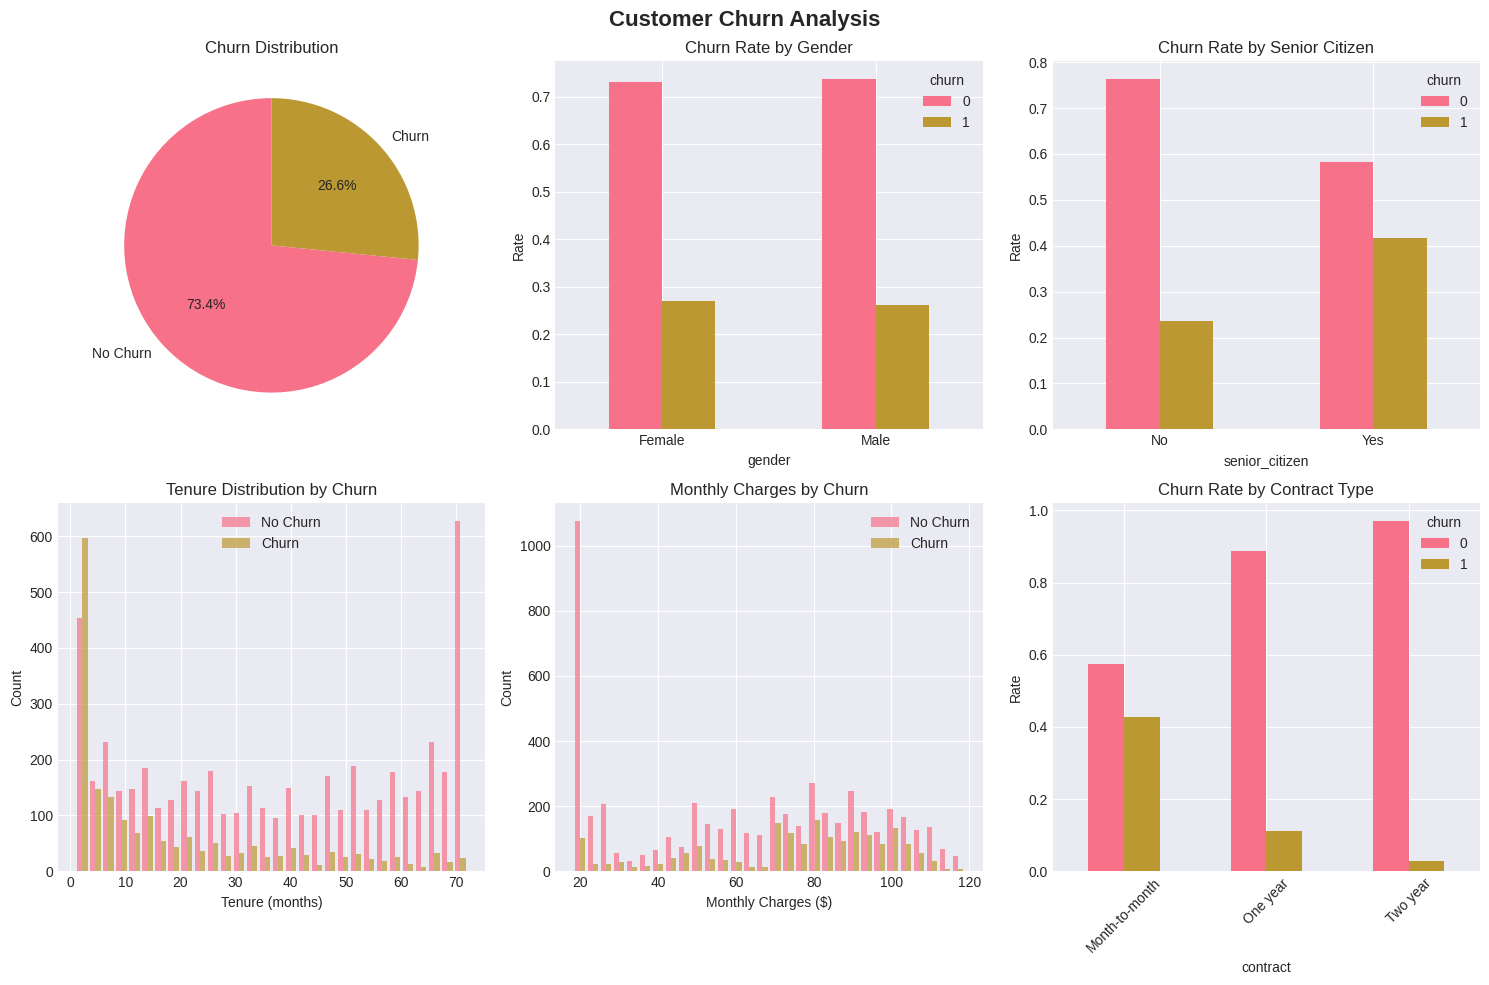

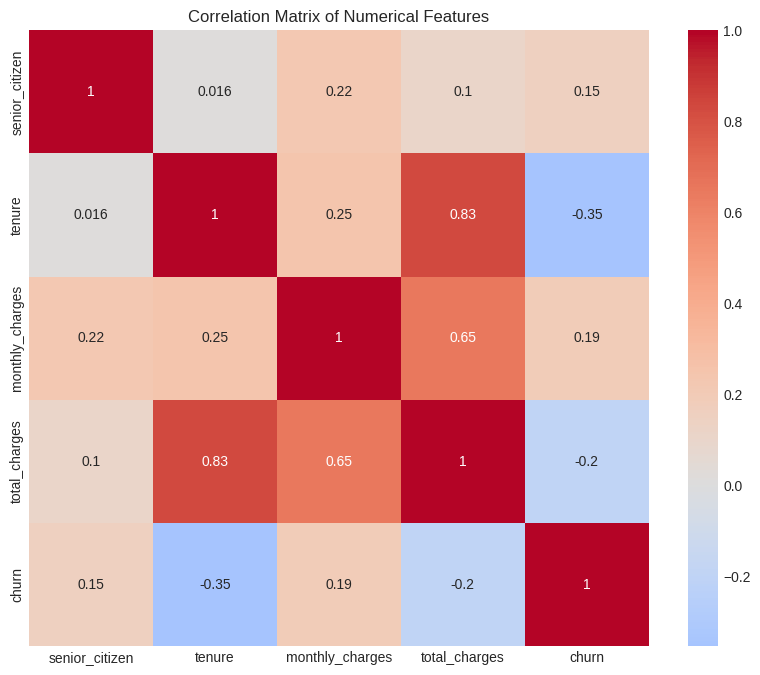

In [5]:
# Step 5: Exploratory Data Analysis
print("="*50)
print("EXPLORATORY DATA ANALYSIS")
print("="*50)

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# 1. Churn Distribution
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
fig.suptitle('Customer Churn Analysis', fontsize=16, fontweight='bold')

# Churn pie chart
churn_counts = df_cleaned['churn'].value_counts()
axes[0, 0].pie(churn_counts.values, labels=['No Churn', 'Churn'],
               autopct='%1.1f%%', startangle=90)
axes[0, 0].set_title('Churn Distribution')

# Churn by gender
churn_gender = pd.crosstab(df_cleaned['gender'], df_cleaned['churn'], normalize='index')
churn_gender.plot(kind='bar', ax=axes[0, 1], rot=0)
axes[0, 1].set_title('Churn Rate by Gender')
axes[0, 1].set_ylabel('Rate')

# Churn by senior citizen
churn_senior = pd.crosstab(df_cleaned['senior_citizen'], df_cleaned['churn'], normalize='index')
churn_senior.plot(kind='bar', ax=axes[0, 2], rot=0)
axes[0, 2].set_title('Churn Rate by Senior Citizen')
axes[0, 2].set_ylabel('Rate')
axes[0, 2].set_xticklabels(['No', 'Yes'])

# Tenure distribution
axes[1, 0].hist([df_cleaned[df_cleaned['churn']==0]['tenure'],
                 df_cleaned[df_cleaned['churn']==1]['tenure']],
                label=['No Churn', 'Churn'], bins=30, alpha=0.7)
axes[1, 0].set_title('Tenure Distribution by Churn')
axes[1, 0].set_xlabel('Tenure (months)')
axes[1, 0].set_ylabel('Count')
axes[1, 0].legend()

# Monthly charges distribution
axes[1, 1].hist([df_cleaned[df_cleaned['churn']==0]['monthly_charges'],
                 df_cleaned[df_cleaned['churn']==1]['monthly_charges']],
                label=['No Churn', 'Churn'], bins=30, alpha=0.7)
axes[1, 1].set_title('Monthly Charges by Churn')
axes[1, 1].set_xlabel('Monthly Charges ($)')
axes[1, 1].set_ylabel('Count')
axes[1, 1].legend()

# Contract type vs churn
churn_contract = pd.crosstab(df_cleaned['contract'], df_cleaned['churn'], normalize='index')
churn_contract.plot(kind='bar', ax=axes[1, 2], rot=45)
axes[1, 2].set_title('Churn Rate by Contract Type')
axes[1, 2].set_ylabel('Rate')

plt.tight_layout()
plt.show()

# Correlation heatmap for numerical features
plt.figure(figsize=(10, 8))
numerical_cols = df_cleaned.select_dtypes(include=[np.number]).columns
correlation_matrix = df_cleaned[numerical_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

In [11]:
# Step 6: Feature Engineering (CORRECTED VERSION)
print("="*50)
print("FEATURE ENGINEERING")
print("="*50)

# Create a copy for feature engineering
df_fe = df_cleaned.copy()

# 1. Create tenure groups (but we'll keep them as numeric codes, not strings)
df_fe['tenure_group'] = pd.cut(df_fe['tenure'], bins=[0, 12, 24, 48, 72],
                                labels=[0, 1, 2, 3])  # Using numbers instead of strings
print("  ✓ Created tenure_group (encoded as 0,1,2,3)")

# 2. Average monthly spending
df_fe['avg_monthly_spend'] = df_fe['total_charges'] / df_fe['tenure'].clip(lower=1)
print("  ✓ Created avg_monthly_spend")

# 3. Service count (how many services customer has)
service_columns = ['phone_service', 'multiple_lines', 'online_security',
                   'online_backup', 'device_protection', 'tech_support',
                   'streaming_tv', 'streaming_movies']
df_fe['service_count'] = (df_fe[service_columns] == 'Yes').sum(axis=1)
print("  ✓ Created service_count")

# 4. Has internet service flag
df_fe['has_internet'] = (df_fe['internet_service'] != 'No').astype(int)
print("  ✓ Created has_internet")

# 5. Payment method groups
df_fe['payment_electronic'] = (df_fe['payment_method'] == 'Electronic check').astype(int)
print("  ✓ Created payment_electronic")

# Check final data types
print("\n✅ Feature engineering completed!")
print(f"Final data types:")
print(df_fe.dtypes.value_counts())
print(f"\nShape: {df_fe.shape}")

FEATURE ENGINEERING
  ✓ Created tenure_group (encoded as 0,1,2,3)
  ✓ Created avg_monthly_spend
  ✓ Created service_count
  ✓ Created has_internet
  ✓ Created payment_electronic

✅ Feature engineering completed!
Final data types:
object      15
int64        6
float64      3
category     1
Name: count, dtype: int64

Shape: (7032, 25)


In [12]:
# Step 7: Prepare Data for Modeling (CORRECTED VERSION)
print("="*50)
print("DATA PREPARATION FOR MODELING")
print("="*50)

# Separate features and target
X = df_fe.drop('churn', axis=1)
y = df_fe['churn']

# Identify categorical and numerical columns
categorical_cols = X.select_dtypes(include=['object']).columns
numerical_cols = X.select_dtypes(include=[np.number]).columns

print(f"Categorical features: {list(categorical_cols)}")
print(f"Numerical features: {list(numerical_cols)}")

# Check if there are any categorical columns left
if len(categorical_cols) > 0:
    print(f"\nWarning: Found {len(categorical_cols)} categorical columns that need encoding!")
    print(f"They are: {list(categorical_cols)}")

    # Encode categorical variables
    from sklearn.preprocessing import LabelEncoder
    le_dict = {}
    X_encoded = X.copy()

    for col in categorical_cols:
        le = LabelEncoder()
        X_encoded[col] = le.fit_transform(X_encoded[col].astype(str))
        le_dict[col] = le
        print(f"  ✓ Encoded: {col}")
else:
    print("\n✅ No categorical columns found - all features are numeric!")
    X_encoded = X.copy()
    le_dict = {}

# Verify no string columns remain
string_columns = X_encoded.select_dtypes(include=['object']).columns
if len(string_columns) > 0:
    print(f"\n❌ ERROR: Still have string columns: {list(string_columns)}")
    print("Let's force convert them:")
    for col in string_columns:
        X_encoded[col] = pd.Categorical(X_encoded[col]).codes
        print(f"  ✓ Force encoded: {col}")

# Scale numerical features
scaler = StandardScaler()
X_encoded[numerical_cols] = scaler.fit_transform(X_encoded[numerical_cols])

# Verify final data types
print("\n✅ Final data types check:")
print(X_encoded.dtypes.value_counts())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n✅ Data preparation completed!")
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")
print(f"Training set data types: {X_train.dtypes.unique()}")

DATA PREPARATION FOR MODELING
Categorical features: ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method']
Numerical features: ['senior_citizen', 'tenure', 'monthly_charges', 'total_charges', 'avg_monthly_spend', 'service_count', 'has_internet', 'payment_electronic']

They are: ['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv', 'streaming_movies', 'contract', 'paperless_billing', 'payment_method']
  ✓ Encoded: gender
  ✓ Encoded: partner
  ✓ Encoded: dependents
  ✓ Encoded: phone_service
  ✓ Encoded: multiple_lines
  ✓ Encoded: internet_service
  ✓ Encoded: online_security
  ✓ Encoded: online_backup
  ✓ Encoded: device_protection
  ✓ Encoded: tech_support
  ✓ Encoded

In [13]:
# Step 8: Model Building - Logistic Regression
print("="*50)
print("MODEL BUILDING - LOGISTIC REGRESSION")
print("="*50)

# Train Logistic Regression
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predictions
lr_pred = lr_model.predict(X_test)
lr_pred_proba = lr_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
lr_accuracy = accuracy_score(y_test, lr_pred)
lr_precision = precision_score(y_test, lr_pred)
lr_recall = recall_score(y_test, lr_pred)
lr_f1 = f1_score(y_test, lr_pred)
lr_auc = roc_auc_score(y_test, lr_pred_proba)

print("\nLogistic Regression Performance:")
print(f"Accuracy:  {lr_accuracy:.3f}")
print(f"Precision: {lr_precision:.3f}")
print(f"Recall:    {lr_recall:.3f}")
print(f"F1-Score:  {lr_f1:.3f}")
print(f"AUC-ROC:   {lr_auc:.3f}")

# Cross-validation
lr_cv_scores = cross_val_score(lr_model, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-validation F1 scores: {lr_cv_scores}")
print(f"Mean CV F1: {lr_cv_scores.mean():.3f} (+/- {lr_cv_scores.std() * 2:.3f})")

MODEL BUILDING - LOGISTIC REGRESSION

Logistic Regression Performance:
Accuracy:  0.800
Precision: 0.643
Recall:    0.559
F1-Score:  0.598
AUC-ROC:   0.836

Cross-validation F1 scores: [0.58110517 0.62056075 0.59479554 0.56146789 0.61041293]
Mean CV F1: 0.594 (+/- 0.042)


In [14]:
# Step 9: Model Building - Random Forest
print("="*50)
print("MODEL BUILDING - RANDOM FOREST")
print("="*50)

# Train Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100, max_depth=10)
rf_model.fit(X_train, y_train)

# Predictions
rf_pred = rf_model.predict(X_test)
rf_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluation metrics
rf_accuracy = accuracy_score(y_test, rf_pred)
rf_precision = precision_score(y_test, rf_pred)
rf_recall = recall_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_auc = roc_auc_score(y_test, rf_pred_proba)

print("\nRandom Forest Performance:")
print(f"Accuracy:  {rf_accuracy:.3f}")
print(f"Precision: {rf_precision:.3f}")
print(f"Recall:    {rf_recall:.3f}")
print(f"F1-Score:  {rf_f1:.3f}")
print(f"AUC-ROC:   {rf_auc:.3f}")

# Cross-validation
rf_cv_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='f1')
print(f"\nCross-validation F1 scores: {rf_cv_scores}")
print(f"Mean CV F1: {rf_cv_scores.mean():.3f} (+/- {rf_cv_scores.std() * 2:.3f})")

MODEL BUILDING - RANDOM FOREST

Random Forest Performance:
Accuracy:  0.790
Precision: 0.637
Recall:    0.492
F1-Score:  0.555
AUC-ROC:   0.834

Cross-validation F1 scores: [0.56343284 0.61596958 0.58935361 0.53592233 0.55513308]
Mean CV F1: 0.572 (+/- 0.056)


MODEL EVALUATION AND COMPARISON

Model Comparison:
              Model  Accuracy  Precision  Recall  F1-Score  AUC-ROC
Logistic Regression     0.800      0.643   0.559     0.598    0.836
      Random Forest     0.790      0.637   0.492     0.555    0.834


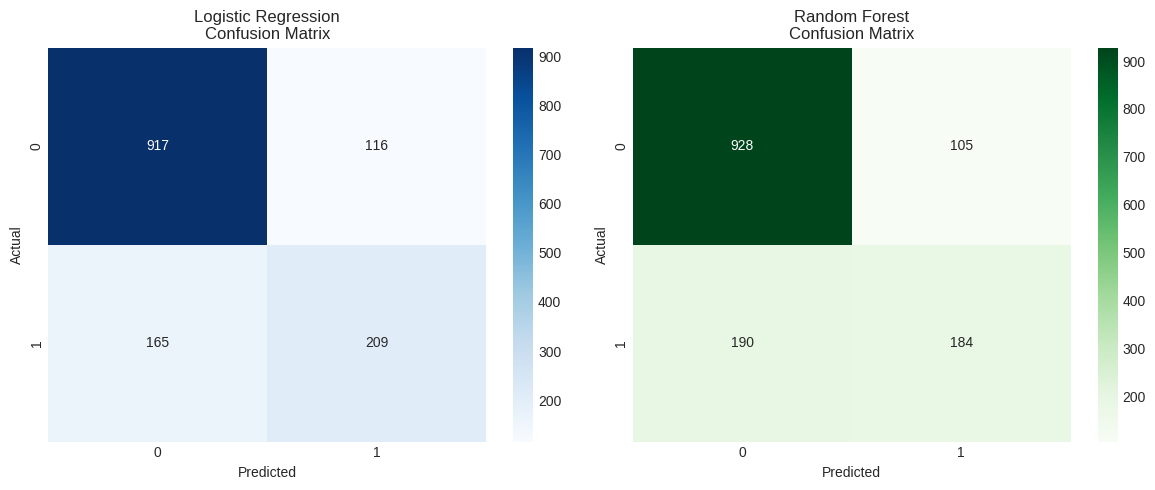

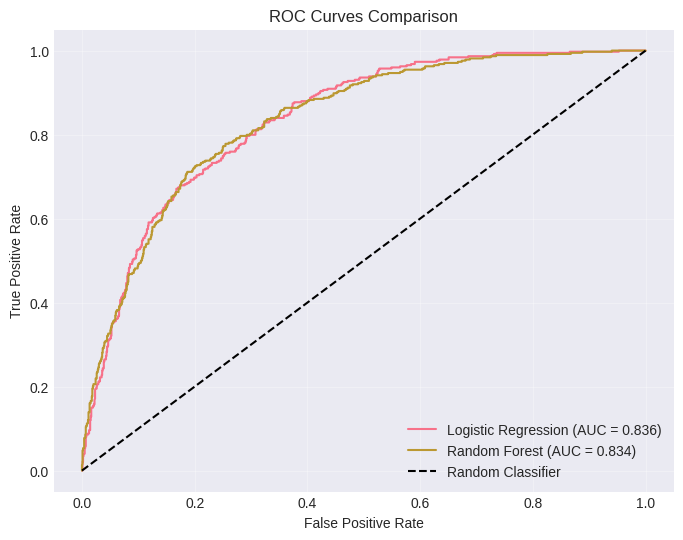

In [15]:
# Step 10: Model Evaluation - Detailed Comparison
print("="*50)
print("MODEL EVALUATION AND COMPARISON")
print("="*50)

# Create comparison dataframe
comparison_data = {
    'Model': ['Logistic Regression', 'Random Forest'],
    'Accuracy': [lr_accuracy, rf_accuracy],
    'Precision': [lr_precision, rf_precision],
    'Recall': [lr_recall, rf_recall],
    'F1-Score': [lr_f1, rf_f1],
    'AUC-ROC': [lr_auc, rf_auc]
}

comparison_df = pd.DataFrame(comparison_data)
print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Logistic Regression Confusion Matrix
lr_cm = confusion_matrix(y_test, lr_pred)
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('Logistic Regression\nConfusion Matrix')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')

# Random Forest Confusion Matrix
rf_cm = confusion_matrix(y_test, rf_pred)
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Random Forest\nConfusion Matrix')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')

plt.tight_layout()
plt.show()

# ROC Curves
plt.figure(figsize=(8, 6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_pred_proba)
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_pred_proba)

plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {lr_auc:.3f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves Comparison')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

FEATURE IMPORTANCE ANALYSIS


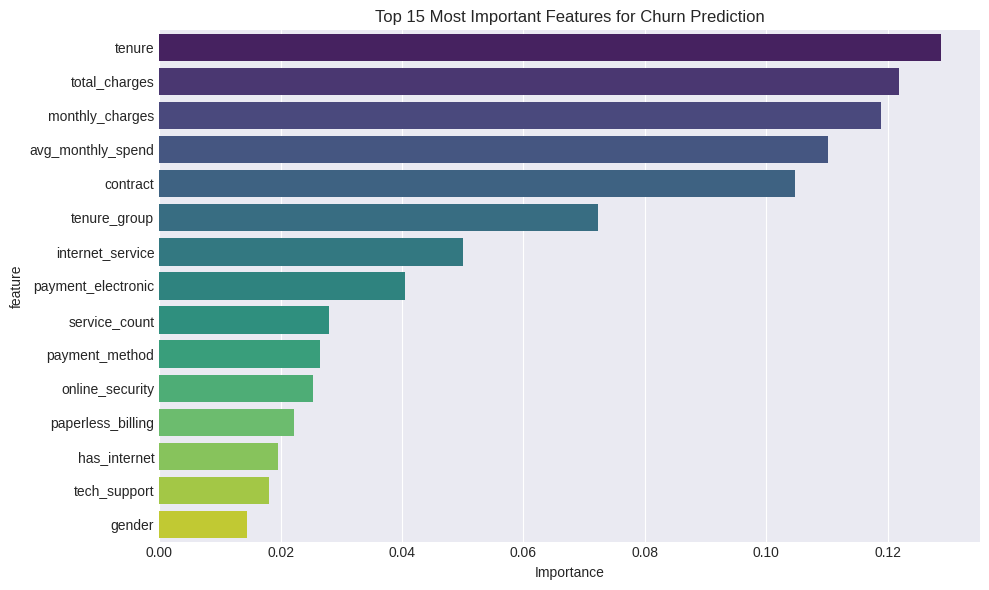


Top 10 Most Important Features:
           feature  importance
            tenure       0.129
     total_charges       0.122
   monthly_charges       0.119
 avg_monthly_spend       0.110
          contract       0.105
      tenure_group       0.072
  internet_service       0.050
payment_electronic       0.041
     service_count       0.028
    payment_method       0.026

Top 10 Positive Coefficients (Increase Churn Risk):
           feature  coefficient
      has_internet        0.968
  internet_service        0.770
     total_charges        0.596
 paperless_billing        0.290
    multiple_lines        0.249
 avg_monthly_spend        0.216
      streaming_tv        0.191
  streaming_movies        0.161
payment_electronic        0.156
     service_count        0.106

Top 10 Negative Coefficients (Decrease Churn Risk):
          feature  coefficient
device_protection       -0.044
     tenure_group       -0.149
       dependents       -0.229
  monthly_charges       -0.233
    online_ba

In [16]:
# Step 11: Feature Importance Analysis
print("="*50)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*50)

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X_encoded.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(15)
sns.barplot(data=top_features, x='importance', y='feature', palette='viridis')
plt.title('Top 15 Most Important Features for Churn Prediction')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Logistic Regression coefficients
lr_coefficients = pd.DataFrame({
    'feature': X_encoded.columns,
    'coefficient': lr_model.coef_[0]
}).sort_values('coefficient', ascending=False)

print("\nTop 10 Positive Coefficients (Increase Churn Risk):")
print(lr_coefficients.head(10).to_string(index=False))

print("\nTop 10 Negative Coefficients (Decrease Churn Risk):")
print(lr_coefficients.tail(10).to_string(index=False))

In [17]:
# Step 12: Business Interpretation
print("="*50)
print("BUSINESS INTERPRETATION")
print("="*50)

print("""
KEY FINDINGS FOR BUSINESS STRATEGY:

1. CRITICAL CHURN DRIVERS:
   - Short tenure customers (< 12 months) are at highest risk
   - Month-to-month contracts show significantly higher churn
   - Fiber optic internet customers churn more (possibly due to competition)
   - Electronic check payment method correlates with higher churn

2. RETENTION RECOMMENDATIONS:

   A. FOR NEW CUSTOMERS (First 12 months):
      - Implement enhanced onboarding program
      - Assign dedicated account manager for first 3 months
      - Offer loyalty discounts for committing to longer contracts

   B. CONTRACT STRATEGY:
      - Create incentives for annual/two-year contracts
      - Offer exclusive benefits for long-term commitments
      - Consider price lock guarantees for extended contracts

   C. SERVICE IMPROVEMENTS:
      - Investigate fiber optic service quality issues
      - Promote tech support services to at-risk customers
      - Bundle popular services to increase switching costs

   D. PAYMENT INCENTIVES:
      - Offer discounts for automatic payments
      - Promote bank transfer/credit card over electronic check
      - Implement early payment rewards program

3. PROACTIVE RETENTION ACTIONS:
   - Flag high-risk customers based on model predictions
   - Reach out before contract expiration
   - Personalize offers based on usage patterns
   - Monitor satisfaction scores for early warning signs

4. ROI ESTIMATION:
   - Reducing churn by 5% could increase revenue by 15-25%
   - Cost of retention vs. acquisition ratio: ~1:5
   - Focus resources on high-value at-risk customers first
""")

BUSINESS INTERPRETATION

KEY FINDINGS FOR BUSINESS STRATEGY:

1. CRITICAL CHURN DRIVERS:
   - Short tenure customers (< 12 months) are at highest risk
   - Month-to-month contracts show significantly higher churn
   - Fiber optic internet customers churn more (possibly due to competition)
   - Electronic check payment method correlates with higher churn

2. RETENTION RECOMMENDATIONS:

   A. FOR NEW CUSTOMERS (First 12 months):
      - Implement enhanced onboarding program
      - Assign dedicated account manager for first 3 months
      - Offer loyalty discounts for committing to longer contracts

   B. CONTRACT STRATEGY:
      - Create incentives for annual/two-year contracts
      - Offer exclusive benefits for long-term commitments
      - Consider price lock guarantees for extended contracts

   C. SERVICE IMPROVEMENTS:
      - Investigate fiber optic service quality issues
      - Promote tech support services to at-risk customers
      - Bundle popular services to increase switch

In [18]:
# Step 14: Save Models and Preprocessing Objects
import joblib
from google.colab import files

# Save models and preprocessors
joblib.dump(rf_model, 'random_forest_churn_model.pkl')
joblib.dump(lr_model, 'logistic_regression_churn_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_dict, 'label_encoders.pkl')

print("✅ Models and preprocessing objects saved!")

# Download files (optional)
# files.download('random_forest_churn_model.pkl')
# files.download('logistic_regression_churn_model.pkl')

✅ Models and preprocessing objects saved!


In [20]:
# Step 15: Prediction Function for New Customers (CORRECTED VERSION)
def predict_churn(new_customer_data):
    """
    Function to predict churn for new customers

    Parameters:
    new_customer_data: dict with customer features

    Returns:
    churn_probability and risk category
    """
    # Convert to DataFrame
    new_df = pd.DataFrame([new_customer_data])

    # Add the engineered features (same as Step 6)
    # Tenure group
    tenure = new_df['tenure'].values[0]
    if tenure < 12:
        new_df['tenure_group'] = 0
    elif tenure < 24:
        new_df['tenure_group'] = 1
    elif tenure < 48:
        new_df['tenure_group'] = 2
    else:
        new_df['tenure_group'] = 3

    # Average monthly spend
    new_df['avg_monthly_spend'] = new_df['total_charges'] / new_df['tenure'].clip(lower=1)

    # Service count
    service_columns = ['phone_service', 'multiple_lines', 'online_security',
                       'online_backup', 'device_protection', 'tech_support',
                       'streaming_tv', 'streaming_movies']
    new_df['service_count'] = (new_df[service_columns] == 'Yes').sum(axis=1)

    # Has internet flag
    new_df['has_internet'] = (new_df['internet_service'] != 'No').astype(int)

    # Payment electronic flag
    new_df['payment_electronic'] = (new_df['payment_method'] == 'Electronic check').astype(int)

    # Apply label encoding to categorical columns
    for col in categorical_cols:
        if col in new_df.columns and col in le_dict:
            try:
                new_df[col] = le_dict[col].transform(new_df[col].astype(str))
            except:
                # Handle unseen categories
                new_df[col] = -1  # Assign -1 for unseen categories
                print(f"Warning: Unseen category in {col}")

    # Scale numerical features
    numerical_present = [col for col in numerical_cols if col in new_df.columns]
    if numerical_present:
        new_df[numerical_present] = scaler.transform(new_df[numerical_present])

    # Ensure all columns match training data
    for col in X_encoded.columns:
        if col not in new_df.columns:
            new_df[col] = 0

    # Reorder columns to match training data
    new_df = new_df[X_encoded.columns]

    # Predict
    proba = rf_model.predict_proba(new_df)[0][1]

    # Risk category
    if proba < 0.3:
        risk = "Low Risk"
    elif proba < 0.6:
        risk = "Medium Risk"
    else:
        risk = "High Risk"

    return {
        'churn_probability': proba,
        'risk_category': risk,
        'recommendation': get_recommendation(risk, proba)
    }

def get_recommendation(risk, proba):
    if risk == "Low Risk":
        return "Maintain regular engagement and satisfaction surveys"
    elif risk == "Medium Risk":
        return "Consider targeted retention offer or contract upgrade incentive"
    else:
        return "Immediate intervention required - personal outreach and special retention offer"

# Example usage with updated customer data (including all engineered features)
new_customer = {
    'gender': 'Male',
    'senior_citizen': 0,
    'partner': 'Yes',
    'dependents': 'No',
    'tenure': 6,
    'phone_service': 'Yes',
    'multiple_lines': 'No',
    'internet_service': 'Fiber optic',
    'online_security': 'No',
    'online_backup': 'Yes',
    'device_protection': 'No',
    'tech_support': 'No',
    'streaming_tv': 'Yes',
    'streaming_movies': 'Yes',
    'contract': 'Month-to-month',
    'paperless_billing': 'Yes',
    'payment_method': 'Electronic check',
    'monthly_charges': 89.99,
    'total_charges': 540.00
}

print("="*50)
print("SAMPLE PREDICTION FOR NEW CUSTOMER")
print("="*50)
result = predict_churn(new_customer)
print(f"Churn Probability: {result['churn_probability']:.2%}")
print(f"Risk Category: {result['risk_category']}")
print(f"Recommendation: {result['recommendation']}")

SAMPLE PREDICTION FOR NEW CUSTOMER
Churn Probability: 80.33%
Risk Category: High Risk
Recommendation: Immediate intervention required - personal outreach and special retention offer


In [21]:
# Save your notebook in Colab
# File → Save a copy in Drive → Name it "Customer_Churn_Prediction_Project"

# Download your notebook
# File → Download → Download .ipynb

# Download your trained models (if you want them locally)
from google.colab import files
files.download('random_forest_churn_model.pkl')
files.download('logistic_regression_churn_model.pkl')
files.download('scaler.pkl')
files.download('label_encoders.pkl')

# Export your results to CSV
results_df = X_test.copy()
results_df['actual_churn'] = y_test
results_df['predicted_churn'] = rf_pred
results_df['churn_probability'] = rf_pred_proba
results_df.to_csv('churn_predictions.csv', index=False)
files.download('churn_predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>